In [150]:
from typing import Dict,TypedDict,Optional
from langgraph.graph import StateGraph,END
from langchain_openai import AzureChatOpenAI
import os
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage
from langchain_groq import ChatGroq
#from langchain_community.llms import OpenLLM
from llama_index.llms.openllm import OpenLLM

In [151]:
from dotenv import load_dotenv

load_dotenv(dotenv_path=".env")

True

In [152]:
gpt_4_mini=AzureChatOpenAI(azure_deployment="gpt-4o-mini-2024-07-18",
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version=os.getenv("AZURE_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    )

In [178]:
mixtral_model = OpenLLM(
            api_base="http://mistral7b.cloudverse.freshworkscorp.com/v1/",
            model="mistralai/Mistral-7B-Instruct-v0.2",
            api_key="na",
            max_tokens=4096,
            temperature=0.1
          )

In [154]:
# output=mixtral_model.complete("Find the next number in the sequence : 2,6,12,20,30,_ ?")

In [155]:
# print(output)



The sequence is obtained by adding consecutive odd numbers to the previous term.

So, 2 + 2 = 4, 4 + 4 = 8, 8 + 4 = 12, 12 + 8 = 20, 20 + 10 = 30.

Therefore, the next number in the sequence is 40 (30 + 10).


In [157]:
# print(os.getenv("GROQ_API_KEY"))

In [158]:
# mixtral_model=ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY"),model_name="mixtral-8x7b-32768",streaming = True)

In [159]:
gemma_model=ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY"),model_name="gemma2-9b-it",streaming = True)

In [160]:
llama_model=ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY"),model_name="llama-3.2-90b-text-preview",streaming = True)

In [183]:
llama_model = OpenLLM(
            api_base="http://llama70bq.cloudverse.freshworkscorp.com/v1",
            model="neuralmagic/Meta-Llama-3.1-70B-Instruct-quantized.w4a16",  #meta-llama/Meta-Llama-3-8B-Instruct
            api_key="na",
            max_tokens=4096
          )

In [184]:
llama_model.complete("what happened in world war 2?")

CompletionResponse(text=" essay\nWorld War 2 was a global conflict that lasted from 1939 to 1945. It was the deadliest war in human history, with an estimated 50-80 million fatalities. The war was fought between two main alliances: the Allies, which consisted of the United States, the United Kingdom, France, and the Soviet Union, among others; and the Axis powers, which included Germany, Italy, and Japan.\nThe war began on September 1, 1939, when Nazi Germany, led by Adolf Hitler, invaded Poland. This act of aggression prompted the United Kingdom and France to declare war on Germany. Over the next year, Germany expanded its territorial control, invading and occupying several European countries, including Denmark, Norway, Belgium, the Netherlands, and France.\nIn June 1941, Germany launched a surprise attack on the Soviet Union, known as Operation Barbarossa. The invasion was a major turning point in the war, as it led to a prolonged and bloody conflict on the Eastern Front. The Soviet 

In [161]:
class GraphState(TypedDict):
    question: Optional[str] = None
    classification : Optional[str] = None
    response: Optional[str]=None
    model : Optional[str]=None



In [162]:
workflow = StateGraph(GraphState)


In [163]:
def analyze_complexity(question):
    """Analyze question complexity to determine which LLM to use"""
    # Use a simpler model to classify complexity
    response = gpt_4_mini.invoke(
        f"Classify the complexity of this question as 'simple' or 'complex' or 'reasoning'. Just output the classification. Question: {question}"
    )
    return {"classification": response.content.strip()}

def handle_simple_query(state):
    """Handle simple queries with gemma model"""
    question = state['question']
    response = gemma_model.invoke(question)
    return {"response": response.content,"model":"gemma2-9b-it"}

def handle_complex_query(state):
    """Handle complex queries with llama"""
    question = state['question']
    response = llama_model.invoke(question)
    return {"response": response.content,"model":"llama-3.2-90b-text-preview"}

# def handle_reasoning_query(state):
#     """Handle reasoning queries with mixtral"""
#     question = state['question']
#     response = mixtral_model.invoke(question)
#     return {"response": response.content}

def handle_reasoning_query(state):
    """Handle reasoning queries with specific prompt template"""
    question = state['question']
    prompt = f"""Please approach this question step by step:
1. First, identify the key components of the problem
2. Then, break down the logical steps needed
3. Finally, provide a well-reasoned conclusion

Question: {question}
"""
    response = mixtral_model.complete(prompt)
    return {"response": response.text,"model":"mixtral-8x7b-32768"}

In [164]:
# Add nodes
workflow.add_node("analyze_complexity", analyze_complexity)
workflow.add_node("handle_simple", handle_simple_query)
workflow.add_node("handle_complex", handle_complex_query)
workflow.add_node("handle_reasoning", handle_reasoning_query)

In [165]:
# Set entry point
workflow.set_entry_point("analyze_complexity")

In [166]:
# Add edges to END
workflow.add_edge("handle_simple", END)
workflow.add_edge("handle_complex", END)
workflow.add_edge("handle_reasoning",END)

In [167]:
# Define routing logic
def route_to_model(state):
    if state["classification"] == "simple":
        return "handle_simple"
    elif state["classification"] == "reasoning":
        return "handle_reasoning"
    else:
        return "handle_complex"

In [168]:
# Add conditional edges
workflow.add_conditional_edges(
    "analyze_complexity",
    route_to_model,
    {
        "handle_simple": "handle_simple",
        "handle_complex": "handle_complex",
        "handle_reasoning": "handle_reasoning"
    }
)


In [169]:
app = workflow.compile()


In [170]:
app.invoke({
    "question": "What is 2+2?"}) 

{'question': 'What is 2+2?',
 'classification': 'simple',
 'response': '2 + 2 = 4\n',
 'model': 'gemma2-9b-it'}

In [171]:
app.invoke({
    "question": "Analyze the causes of World War I"})

{'question': 'Analyze the causes of World War I',
 'classification': 'complex',
 'response': "The causes of World War I can be attributed to a complex interplay of various factors, including:\n\n1. **Imperialism**: European nations were competing for colonies and resources in Africa and Asia, leading to tensions and rivalries. The Scramble for Africa (1881-1914) and the partitioning of China (1894-1902) are notable examples.\n\n2. **Nationalism**: The rise of nationalism in various countries contributed to the war. Countries like Germany, Italy, and France were seeking to assert their dominance and secure their interests, often at the expense of other nations.\n\n3. **Militarism**: The buildup of military forces and the glorification of war in many European countries created an atmosphere of aggression and competition. This led to an arms race, with countries like Germany, France, and Britain vying for military superiority.\n\n4. **Alliances**: The complex system of alliances between E

In [172]:
app.invoke({
    "question": "Find the next number in the sequence : 2,6,12,20,30,_ ?"})  

{'question': 'Find the next number in the sequence : 2,6,12,20,30,_ ?',
 'classification': 'reasoning',
 'response': '\nStep 1: Identify the key components of the problem\nThe problem statement provides a sequence of numbers. The task is to find the next number in the sequence.\n\nStep 2: Break down the logical steps needed\n1. Observe the sequence and identify any patterns or rules.\n2. Use the identified pattern or rule to find the next number.\n\nStep 3: Provide a well-reasoned conclusion\n1. Observe the sequence: The difference between consecutive terms is increasing by 4, 6, 8, 10.\n2. Use the identified pattern to find the next difference: The difference between 30 and 20 is 10. So, the difference between the next term and 30 should be 10.\n3. Find the next term: The next term in the sequence is 30 + 10 = 40.\n\nTherefore, the next number in the sequence is 40.',
 'model': 'mixtral-8x7b-32768'}

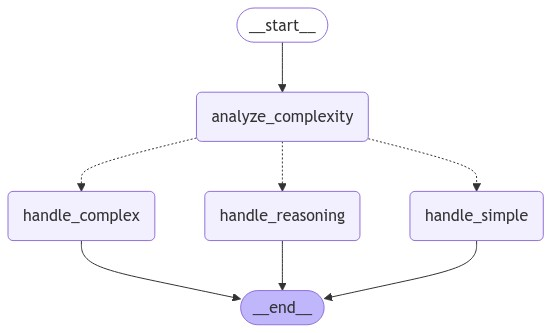

In [43]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))